In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [59]:
cdc_types = ['replication', 'trigger', 'timestamp']
all_runs = {}

for cdc in cdc_types:
    runs = []
    for i in range(1, 2):
        with open(f"data/stress_{cdc}_{i}.json", "r") as f:
            runs.append([json.loads(line) for line in f])
    all_runs[cdc] = runs

In [60]:
def get_msg_deltas(lines):
    df = pd.json_normalize(lines)
    # extract the relevant columns and create a new data frame
    df['timestamp'] = pd.to_datetime(df['data.time'])
    df['value'] = df['data.value']
    df = df[['timestamp', 'metric', 'value']].sort_values('timestamp')

    # change the df to have one row per timestamp with values for all metrics
    # if a value does not exist it is 0 and if multiple exist they are summed up
    df = df.pivot_table(index='timestamp', columns='metric',
                           values='value', aggfunc='sum').fillna(0)

    # add columns for cumulative connections and msg_delta
    df['connections'] = df['single_client_connections'].cumsum()
    df['msg_delta'] = (
        df['single_client_msgs_sent'].cumsum()
        - df['single_client_msgs_received'].cumsum()
    )
    return df.groupby('connections')['msg_delta'].mean()

                  run1
connections           
326.0        29.000000
328.0        29.000000
329.0        37.943813
                  run1
connections           
333.0        41.000000
334.0        41.333333
335.0        52.076625
                   run1
connections            
320.0        131.000000
321.0        132.500000
322.0        176.108974


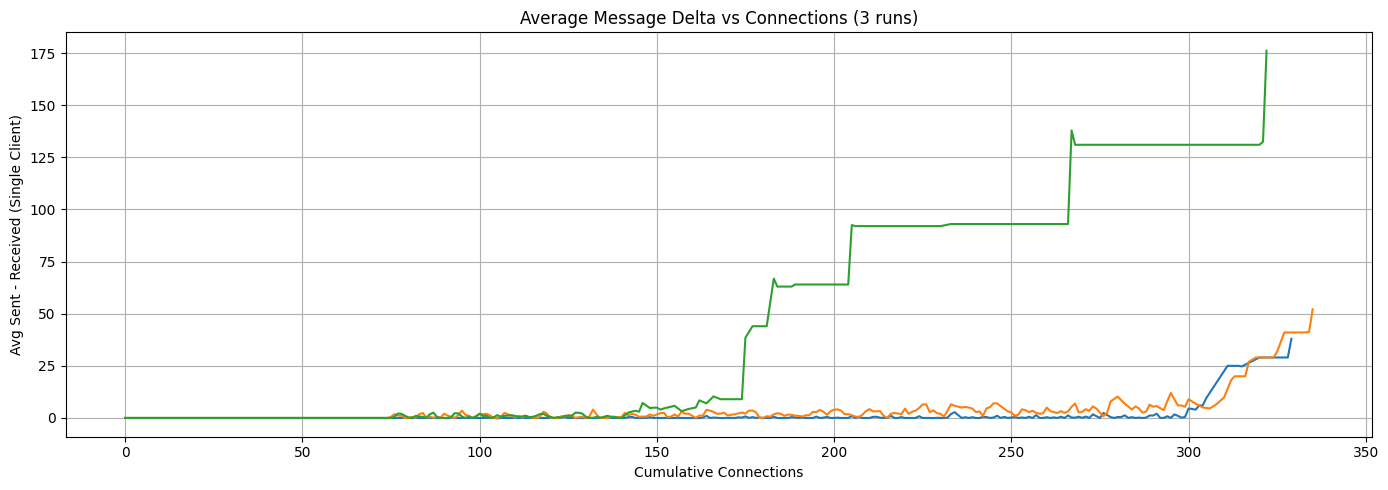

In [61]:
plt.figure(figsize=(14, 5))

for cdc in cdc_types:
    deltas_per_run = []
    for i, run_data in enumerate(all_runs[cdc], 1):
        msg_deltas = get_msg_deltas(run_data)
        msg_deltas.name = f'run{i}'
        deltas_per_run.append(msg_deltas)

    # Align by connection count, then average across runs
    comb = pd.concat(deltas_per_run, axis=1)

    print(comb.tail(3))


    avg = comb.dropna().mean(axis=1)

    #plot
    plt.plot(avg.index, avg.values, label=cdc)

plt.xlabel("Cumulative Connections")
plt.ylabel("Avg Sent - Received (Single Client)")
plt.title("Average Message Delta vs Connections (3 runs)")
plt.grid(True)
plt.tight_layout()
plt.show()